In [56]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import quandl
from init_objects import *
from functions.stylizedfacts import *
from simfinmodel import *
from functions.helpers import hurst, organise_data

# Fundamentals unhinged replication notebook

## Estimating fundamentals following Boswijk et al. (2007)

Boswijk et al. (2007) calculate the fundamental value using the static gordon growth model (Gordon, 1962). Following their approach, I calculate the fundamental value as the NPV of current cash flows at a constant rate of growth.

$P^f_t = \frac{1 + g}{r - g} D_t,$

where $g$ is the constant growth rate of cash flows (measured as the rolling average of growth rates of real dividends), $r = \frac{D_t}{P_{t-1}} + g$ is the discount rate and $D_t$ is the dividend amount at time $t$. $\frac{D_t}{P_{t-1}}$ is the average cash flow yield.

In [54]:
start_date = '1960-01-01'
end_date = '2016-8-31'
window = 320

spy_real_price = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_real_price = spy_real_price.rename(columns={"Value": "price"})

spy_returns = spy_real_price.pct_change()[1:]

spy_dividends = quandl.get("MULTPL/SP500_DIV_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_dividends = spy_dividends.rename(columns={"Value": "dividends"})
spy_dividends.index = spy_dividends.index + pd.offsets.MonthBegin(1)
spy_all = spy_dividends.join(spy_real_price)

spy_t_bill = quandl.get("FRED/INTGSTUSM193N", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_t_bill = spy_t_bill.rename(columns={"Value": "dividends"})

spy_all['t_bill_int'] = spy_t_bill / 100

spy_all['div_growth'] = spy_all['dividends'].pct_change()
spy_all['av_div_growth'] = spy_all['div_growth'].rolling(window=window,center=False).mean()
spy_all['yield'] = spy_all['dividends'].iloc[1:] / spy_all['price'].iloc[:-1]
spy_all['ml_discount'] = [0.052 for x in range(len(spy_all))]
spy_all['fixed_yield'] = spy_all['t_bill_int'] + spy_all['ml_discount']

spy_all = spy_all.iloc[-window:-1]

spy_all['fundamental'] = ((1 + spy_all['av_div_growth']) / (spy_all['fixed_yield'] - spy_all['av_div_growth'])) * spy_all['dividends']
spy_all['dev_fundamental'] = (spy_all['price'] - spy_all['fundamental']) / spy_all['fundamental']

In [57]:
spy_autocorrelation = autocorrelation_returns(spy_returns['price'], 25)
spy_kurtosis = kurtosis(spy_returns['price'])
spy_autocorrelation_abs = autocorrelation_abs_returns(spy_returns['price'], 25)
spy_hurst = hurst(spy_all['price'])

#spy_dev_fund_hurst = hurst(spy_all['dev_fundamental'].iloc[:-1])
av_def_fund = abs(np.mean(spy_all['dev_fundamental']))
stylized_facts_spy = [spy_kurtosis, spy_autocorrelation_abs, spy_hurst, av_def_fund]

stylized_facts_spy = pd.DataFrame(stylized_facts_spy, columns=['S&P500'], 
             index=['kurtosis', 'autocorrelation_abs', 'hurst', 'av_dev_from_fund']).to_dict()['S&P500']

In [58]:
stylized_facts_spy

{'autocorrelation_abs': 0.049914003700974562,
 'av_dev_from_fund': 2.0192681168484445,
 'hurst': 0.41423988932290962,
 'kurtosis': 3.0676490833426238}

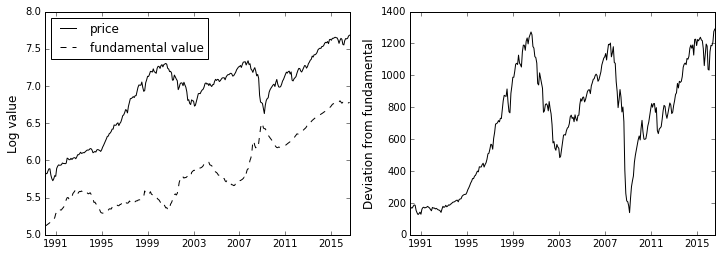

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(spy_all['price'].iloc[:].index, np.log(spy_all['price']).iloc[:], 'k-', label='price')
ax1.plot(spy_all['fundamental'].iloc[:].index, np.log(spy_all['fundamental']).iloc[:], 'k--', label='fundamental value')
ax1.set_ylabel('Log value', fontsize='12')
ax1.legend(loc='best')

ax2.plot(spy_all['dev_fundamental'].iloc[:].index, spy_all['dev_fundamental'].iloc[:], 'k-')
ax2.set_ylabel('Deviation from fundamental', fontsize='12')

fig.savefig('fundamentals.png')

The Dickey Fuller test for mean reversion indicates that the null hypothesis of mean reversion can definetely be rejected. 

In [6]:
ts.adfuller(spy_all['dev_fundamental'].iloc[-200:-1], 1)

(-1.670991314193607,
 0.44611716759958997,
 1,
 197,
 {'1%': -3.463987334463603,
  '10%': -2.5746515171738515,
  '5%': -2.8763259091636213},
 2103.9146662418225)

The Hurst component also indicates that there is a significant deviation from fundamentals.

In [7]:
hurst(spy_all['dev_fundamental'].iloc[:-1])

0.40316509821294022

In [8]:
hurst(spy_all['price'])

0.41423988932290962

# Model parameters

In [68]:
NRUNS = 50

In [67]:
parameters = {'fundamental_value': 100,
 'horizon_max': 22,
 'horizon_min': 2,
 'max_order_expiration_ticks': 24,
 'n_traders': 1981,
 'spread_max': 0.1034423464335639,
 'std_fundamental': 0.10754244839080045,
 'std_noise': 0.20680836615919262,
 'std_vol': 11,
 'ticks': 1000,
 'trader_sample_size': 21,
 'w_buy_hold': 0.0,
 'w_fundamentalists': 59.96213213200949,
 'w_mean_reversion': 72.9727690079459,
 'w_momentum': 94.61305458063075,
 'w_random': 44.351363543793354}


## Baseline monte carlo simulations

In [69]:
traders = []
obs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects(parameters, seed)
    traders, orderbook = sim_fin_model(traders, orderbook, parameters, seed)
    traders.append(traders)
    obs.append(orderbook)

## Model Baseline Dynamics

In [70]:
burn_in_period = 100 

In [71]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs)

In [72]:
mc_dev_fundaments = mc_prices - mc_fundamentals

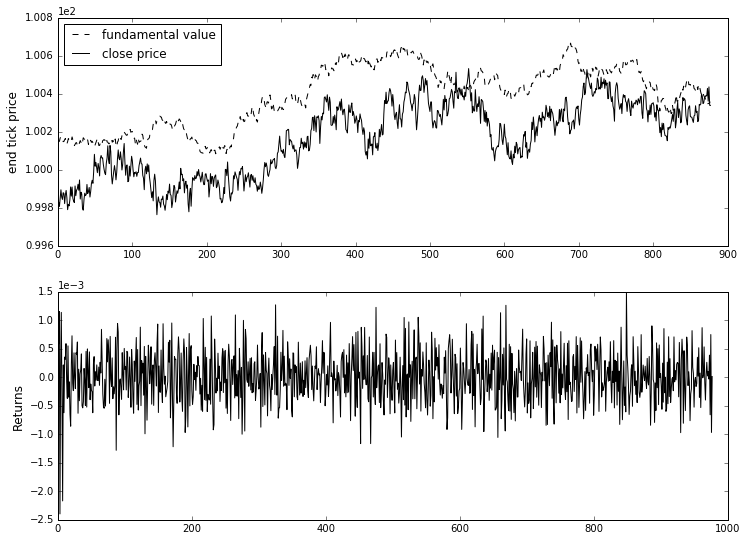

In [73]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='fundamental value')
ax1.plot(mc_prices.index, mc_prices.mean(axis=1), 'k-', label='close price')
# ax1.fill_between(mc_prices.index, 
#                  mc_prices.mean(axis=1)+mc_prices.std(axis=1), 
#                  mc_prices.mean(axis=1)-mc_prices.std(axis=1), 
#                  alpha=0.3, facecolor='black')

ax1.set_ylabel('end tick price', fontsize='12')
ax1.legend(loc='best')

ax2.plot(mc_returns.index, mc_returns.mean(axis=1), 'k-')
ax2.set_ylabel('Returns', fontsize='12')

# ax3.plot(mc_volatility.index, mc_volatility.mean(axis=1), 'k-')
# ax3.set_ylabel('volatility', fontsize='12')

# ax3.bar(mc_volume.index, mc_volume.mean(axis=1), color='k', edgecolor='k')
# ax3.set_ylabel('Volume', fontsize='12')
# ax3.set_xlabel('Ticks', fontsize='12')

for ax in [ax1, ax2]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
fig.savefig('model_dynamics.png')

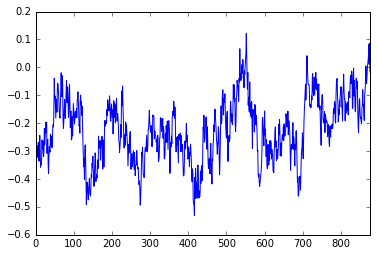

In [74]:
mc_dev_fundaments.mean(axis=1).plot()

In [75]:
hurst(mc_dev_fundaments.mean(axis=1))

0.24463564609860158

# Stylized facts simulations

In [76]:
stylized_facts = {'autocorrelation': np.inf, 'kurtosis': np.inf, 'autocorrelation_abs': np.inf,
                          'hurst': np.inf, 'av_dev_from_fund': np.inf}


mean_autocor = []
mean_autocor_abs = []
mean_kurtosis = []
long_memory = []
#long_memory_deviation_fundamentals = []
av_deviation_fundamental = []
for col in mc_returns:
    mean_autocor.append(np.mean(mc_autocorr_returns[col][1:])) #correct?
    mean_autocor_abs.append(np.mean(mc_autocorr_abs_returns[col][1:]))
    mean_kurtosis.append(mc_returns[col][2:].kurtosis())
    long_memory.append(hurst(mc_prices[col][2:]))
    av_deviation_fundamental.append(np.mean(mc_dev_fundaments[col][1:]))

stylized_facts['autocorrelation'] = np.mean(mean_autocor)
stylized_facts['kurtosis'] = np.mean(mean_kurtosis)
stylized_facts['autocorrelation_abs'] = np.mean(mean_autocor_abs)
stylized_facts['hurst'] = np.mean(long_memory)
stylized_facts['av_dev_from_fund'] = abs(np.mean(av_deviation_fundamental))

stylized_facts

{'autocorrelation': -0.01846652936099203,
 'autocorrelation_abs': 0.030949243031167563,
 'av_dev_from_fund': 0.22294438599547101,
 'hurst': 0.26810238279100745,
 'kurtosis': 4.6910603157091408}

## No autocorrelation in returns + volatility clustering

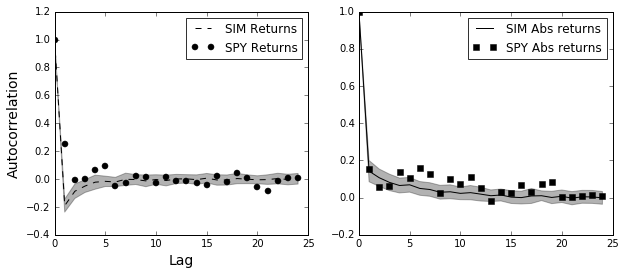

In [77]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

lenght = 20

ax1.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1), 'k--', label='SIM Returns')
ax1.plot(mc_autocorr_returns.index, autocorr_spy_returns, 'ko', label='SPY Returns')
ax1.fill_between(mc_autocorr_returns.index, 
                 mc_autocorr_returns.mean(axis=1)+mc_autocorr_returns.std(axis=1), 
                 mc_autocorr_returns.mean(axis=1)-mc_autocorr_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax2.plot(mc_autocorr_abs_returns.index, mc_autocorr_abs_returns.mean(axis=1), 'k-', label='SIM Abs returns')
ax2.plot(mc_autocorr_returns.index, autocorr_spy_abs_returns, 'ks', label='SPY Abs returns')
ax2.fill_between(mc_autocorr_abs_returns.index, 
                 mc_autocorr_abs_returns.mean(axis=1)+mc_autocorr_abs_returns.std(axis=1), 
                 mc_autocorr_abs_returns.mean(axis=1)-mc_autocorr_abs_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

ax2.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_xlabel('Lag', fontsize='14')

fig.savefig('auto_correlation.png')

# Fat tails & Long memory

In [78]:
av_fat_tails = np.mean([mc_returns[col].kurtosis() for col in mc_returns])

In [79]:
mean_kurtosis = []
long_memory = []
for col in mc_returns:
    kurtosis = mc_returns[col][2:].kurtosis()
    lm = hurst(mc_prices[col][2:])
    mean_kurtosis.append(kurtosis)
    long_memory.append(lm)
np.mean(mean_kurtosis)
np.mean(lm)

0.19437450141359389

## Descriptive statistics



In [80]:
print(stylized_facts)
print(stylized_facts_spy)
'autocorrelation'
'autocorrelation_abs'
'kurtosis'
'hurst'
'av_dev_from_fund'

{'av_dev_from_fund': 0.22294438599547101, 'kurtosis': 4.6910603157091408, 'autocorrelation': -0.01846652936099203, 'autocorrelation_abs': 0.030949243031167563, 'hurst': 0.26810238279100745}
{'av_dev_from_fund': 2.0192681168484445, 'kurtosis': 3.0676490833426238, 'hurst': 0.41423988932290962, 'autocorrelation_abs': 0.049914003700974562}


'av_dev_from_fund'

In [81]:
stats = {'S&P500':[spy_autocorrelation, stylized_facts_spy['autocorrelation_abs'], stylized_facts_spy['kurtosis'], stylized_facts_spy['hurst'], stylized_facts_spy['av_dev_from_fund']],
         'sim': [stylized_facts['autocorrelation'],stylized_facts['autocorrelation_abs'],stylized_facts['kurtosis'],stylized_facts['hurst'],stylized_facts['av_dev_from_fund']]}
pd.DataFrame(stats, index=['autocorrelation', 'autocorrelation_abs', 'kurtosis', 'hurst', 'av_dev_from_fund'])

,S&P500,sim
autocorrelation,0.000303,-0.018467
autocorrelation_abs,0.049914,0.030949
kurtosis,3.067649,4.691060
hurst,0.414240,0.268102
av_dev_from_fund,2.019268,0.222944


In [82]:
spy_autocorrelation = autocorrelation_returns(spy_returns['price'], 25)
spy_kurtosis = kurtosis(spy_returns['price'])
spy_autocorrelation_abs = autocorrelation_abs_returns(spy_returns['price'], 25)
spy_hurst = hurst(spy_all['price'])

#spy_dev_fund_hurst = hurst(spy_all['dev_fundamental'].iloc[:-1])
av_def_fund = abs(np.mean(spy_all['dev_fundamental']))
stylized_facts_spy = [spy_kurtosis, spy_autocorrelation_abs, spy_hurst, av_def_fund]

stylized_facts_spy = pd.DataFrame(stylized_facts_spy, columns=['S&P500'], 
             index=['kurtosis', 'autocorrelation_abs', 'hurst', 'av_dev_from_fund']).to_dict()['S&P500']

TypeError: 'numpy.float64' object is not callable